# Assignment 1.2 - AI in Education, ETH Zurich


In the assignment 1.2, we will explore correlation mining and clustering techniques using the same dataset - dataset about students in two portuguese schools. 

The dataset is taken from P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. More details can be found at https://www.kaggle.com/larsen0966/student-performance-data-set. 

The dataset consists of 639 samples (students) and 33 features (demographics, school-related features,...). A full description of the features can be found at https://archive.ics.uci.edu/ml/datasets/Student+Performance. 

This assignment is a mix of theoretical and practical questions. Keep in mind that we expect brief answers in the analysis questions. A suggested length is indicated next to the analysis questions. 

First, let's download all necessary modules. You can add the modules you wish to use as well.

In [2]:
!pip install causal-learn

# general
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# model evaluation
from sklearn.model_selection import train_test_split

# IMPORTANT: please use this constant as a seed everywhere for reproducibility
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Here any module you wish to download

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 172 kB 8.2 MB/s 


In [3]:
from zipfile import ZipFile
import io
from urllib.request import urlopen

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
r = urlopen(URL).read()
zip_file = ZipFile(io.BytesIO(r))
students_port = pd.read_csv(zip_file.open('student-por.csv'), delimiter=";")

Let's now verify we have all the information we need. You should obtain a dataset with 649 students and 33 features.

In [4]:
print("This dataset consists of {} students with {} associated features".format(students_port.shape[0],students_port.shape[1]))

This dataset consists of 649 students with 33 associated features


## Part 1: Causal mining (2 questions)

**Q1.1:** Based on your experience from assignment 1.1, draw the causal graph for the target variable "G3" based on your domain knowledge. Include only these variables in the graph: **study time, absences, higher, health**. Explain rationale behind your decisions, include and describe your final causal graph. Are there any other untracked data you suggest to start tracking in order to best predict G3 grade?

*Hint*: Include the causal graph here as an image.

**A1.1:** 
* In my perspective, health can influence whether a student wants to persue higher education, the study time and absence, because if a student is unhealty, she(he) may take more time to treat the condition. The willingness of taking higher education influences the study time and absence because these two features show the students' learning motivation. All of these may have influence on the G3 grade because health influences the students' exam status, other features reflects the attitude of the student of getting good grade
* I suggest we should also track the total time spent on revision for the students.

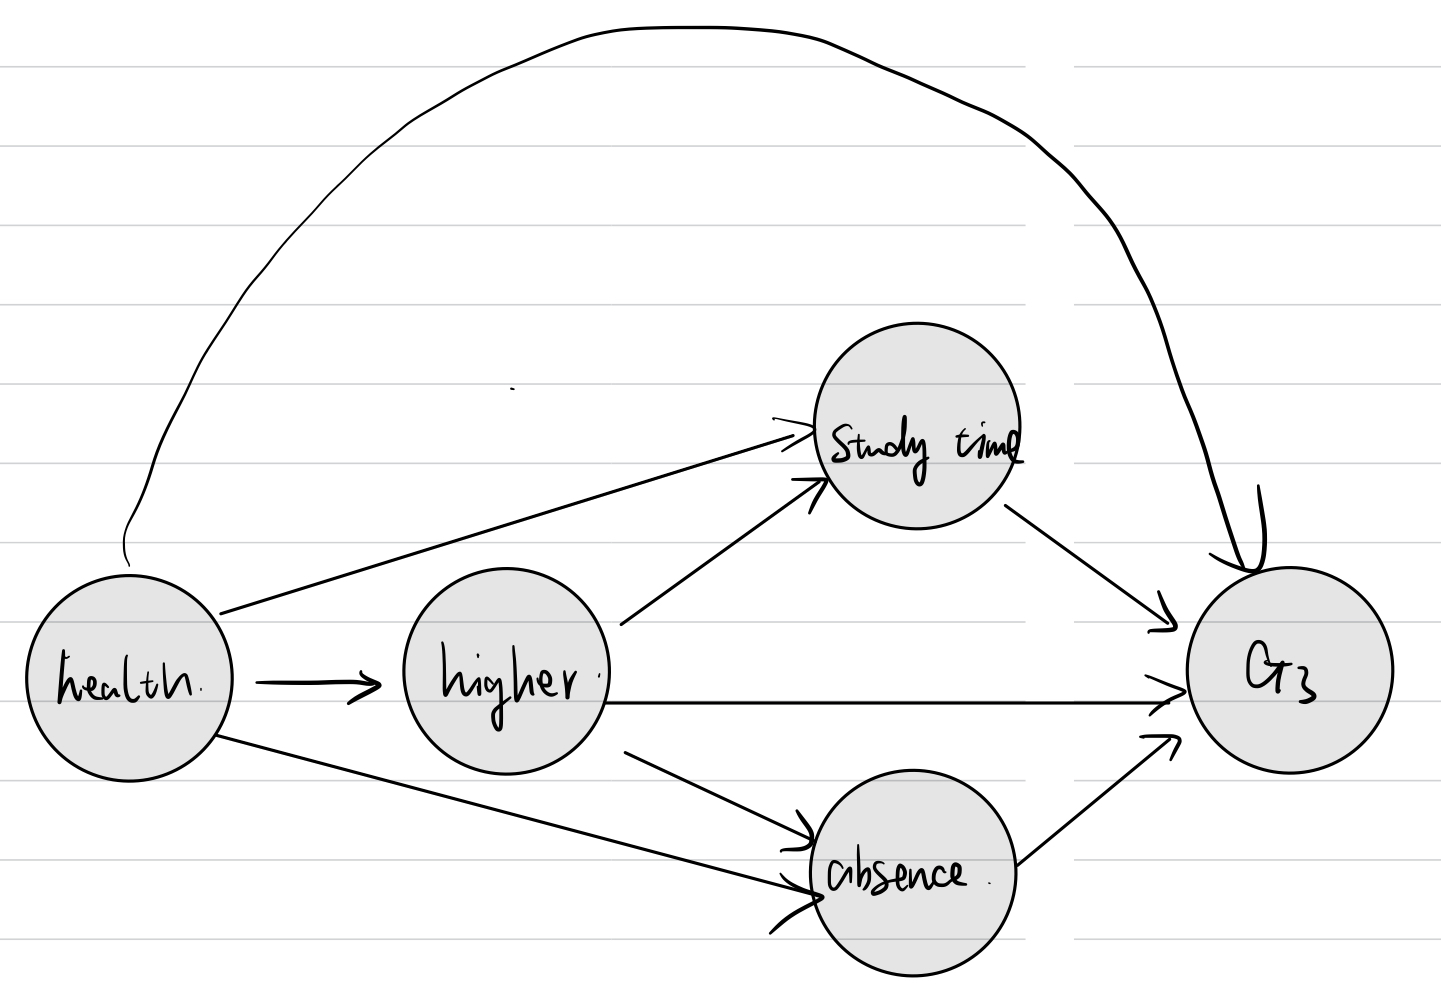

**Q1.2:** Run PC algorithm using ***causallearn*** Python library with the same variables as in Q1.1. Check whether your hypothesis is consistent with the graph derived from data. If not, explain possible reasons for the mismatch.

Hint: Check the expected format and change categorical variables to binary.


**A1.2:**
The result is not consistent. The health may not have big effect on the study time, absence, and willingness of persuing higher education. This may caused by the bias of data collection, since most of the health problem are mildly symptomatic, thus do not change the total study time, absence, and willingness of taking higher degree. The bidirectional relationship between study time, absence, and higher makes more sence than my derivation. 

  0%|          | 0/5 [00:00<?, ?it/s]

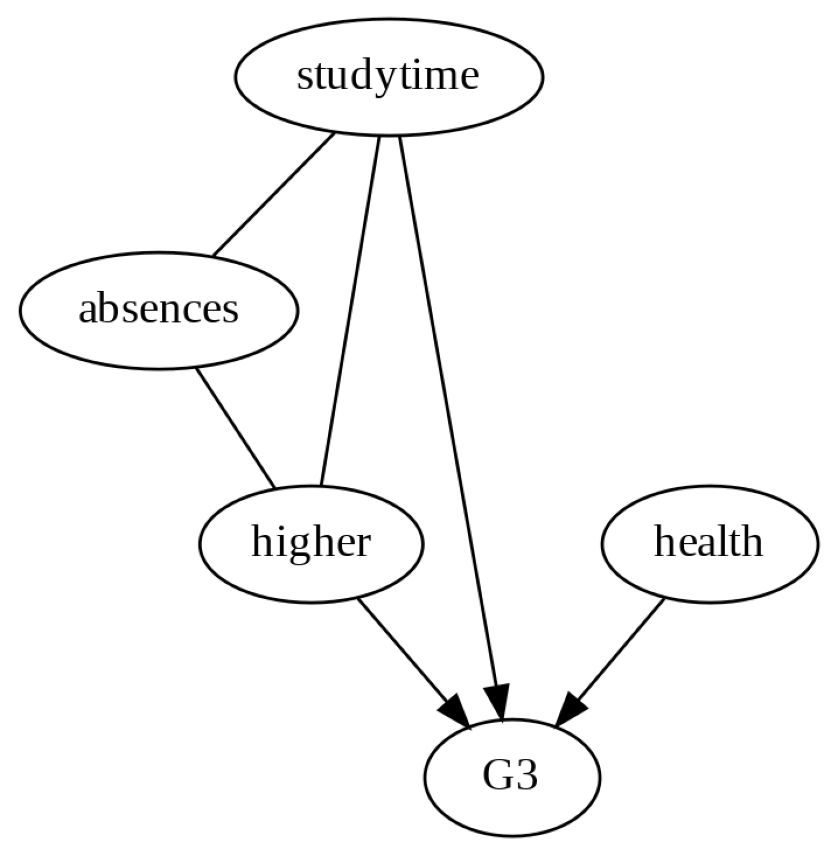

In [5]:
from causallearn.search.ConstraintBased.PC import pc
related_features = ["studytime", "absences", "higher", "health", "G3"]
X = students_port[related_features]

from sklearn.preprocessing import LabelEncoder, StandardScaler
X_num_col = X._get_numeric_data().columns.tolist()
X_cat_col = set(X.columns) - set(X_num_col)
# one-hot encoding
lb = LabelEncoder()
X_transformed = X.copy()
for col_name in X_cat_col:
  X_transformed[col_name] = lb.fit_transform(X[col_name])

cg = pc(X_transformed.to_numpy())
cg.draw_pydot_graph(related_features)

## Part 2: Correlation mining and feature transformation (4 questions)

Let's explore the link between our target variable ("G3") and our predictor variables. 

In [6]:
X = students_port.drop("G3",axis=1)
y = students_port[["G3"]]

Normalizing features first.

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

X_transformed = pd.DataFrame(index=X.index)

# iterate through every possible feature
for feature in X.columns:
    
    # if the feature is already numerical, keep as is -- scaling will be performed later for PCA and for regr/classif
    if X[feature].dtype==np.int64:
        X_transformed[feature] = X[feature]
        
    # if the feature is binary, encode into 0 and 1
    elif len(np.unique(X[feature].values.ravel()))==2:
        le = LabelEncoder()
        X_transformed[feature] = le.fit_transform(X[feature])
        
    # if the feature is categorical, encode into dummy variables
    else:
        le = OneHotEncoder()
        new_cols = le.fit_transform(X[feature].values.reshape(-1,1)).toarray()
        df = pd.DataFrame(new_cols,columns=feature+"_"+np.array(le.categories_[0]))
        X_transformed = pd.concat([X_transformed,df],axis=1)

**Q2.1**: How many relevant features are significantly correlated with the grade in the third semester? What are the five most correlated or anti-correlated features and their associated correlation coefficient($R$)? (*note*: we are looking for the five highest absolute associated $R$s)

Use Spearman correlation when relevant and a cut-off threshold $\alpha$ of 0.05

In [8]:
# Your code here
from scipy.stats import spearmanr
X_y = X_transformed.copy()
X_y['G3'] = y['G3']
X_y_corr, p = spearmanr(X_y)
(p[-1, :-1] < 0.05).sum()

28

In [9]:
indices = np.argsort(-abs(X_y_corr[-1, :-1]))[:5]
print(X_transformed.columns[indices])
print(abs(X_y_corr[-1, :-1])[indices])

Index(['G2', 'G1', 'failures', 'higher', 'school'], dtype='object')
[0.94445119 0.88328764 0.4483603  0.3532177  0.28531729]


**A2.1**: 
* 28 features are significantly 
correlated with G3. 
* The five most correlated (anti-correlated) features and correlation coefficients are 
  * G2:          0.944451
  * G1:          0.883288
  * failures:    0.448360
  * higher:      0.353218
  * school:      0.285317
  
  
  
  
  

**Q2.2**: How many features are still significantly correlated after Bonferroni correction? How about after FDR correction? 

Use the same $\alpha$ and report the corrected p-values of the 5 most correlated features. 

In [10]:
# Your code here
from statsmodels.stats.multitest import multipletests
_, p_bonferroni, _, _ = multipletests(p[-1, :-1], alpha = 0.05, method = 'bonferroni')
_, p_fdr, _, _ = multipletests(p[-1, :-1], alpha = 0.05, method = 'fdr_bh')
print((p_bonferroni < 0.05).sum())
print(p_bonferroni[indices])
print((p_fdr < 0.05).sum())
print(p_fdr[indices])

21
[3.17986975e-313 2.24431853e-213 9.21357008e-032 7.49222055e-019
 5.72068434e-012]
27
[3.17986975e-313 1.12215927e-213 3.07119003e-032 1.87305514e-019
 1.14413687e-012]


**A2.2**: 
* Bonferroni:  21 features are still significantly correlated after Bonferroni correction
  * corrected p-values: [3.17986975e-313, 2.24431853e-213, 9.21357008e-032, 7.49222055e-019,5.72068434e-012]
*   27 features are still significantly correlated after FDR correction
  * corrected p-values: [3.17986975e-313, 1.12215927e-213, 3.07119003e-032, 1.87305514e-019,1.14413687e-012]

**Q2.3**: When would you choose what correction method and why? (1-2 sentences) 

**A2.3**: Since the Bonferroni method directly multiplies the p value by the number of tests. It is suitable when there is not so much tests. Because if there is many test, there is one false positive case seems more reasonable. FDR is better when there are many tests, since it controls the false discovery rate by sorting the p-values and find the proportion of p-values that are assigned to be true discovery. 

We will now visualize the relationship between the five most correlated predictor variables and the target variable.

In [11]:
# add here the names of the three most correlated variables
features_to_viz = ['G2', 'G1', 'failures', 'higher', 'school']

# note: if you wish to visualize other relationships, you can change the feature names to those you are interested in

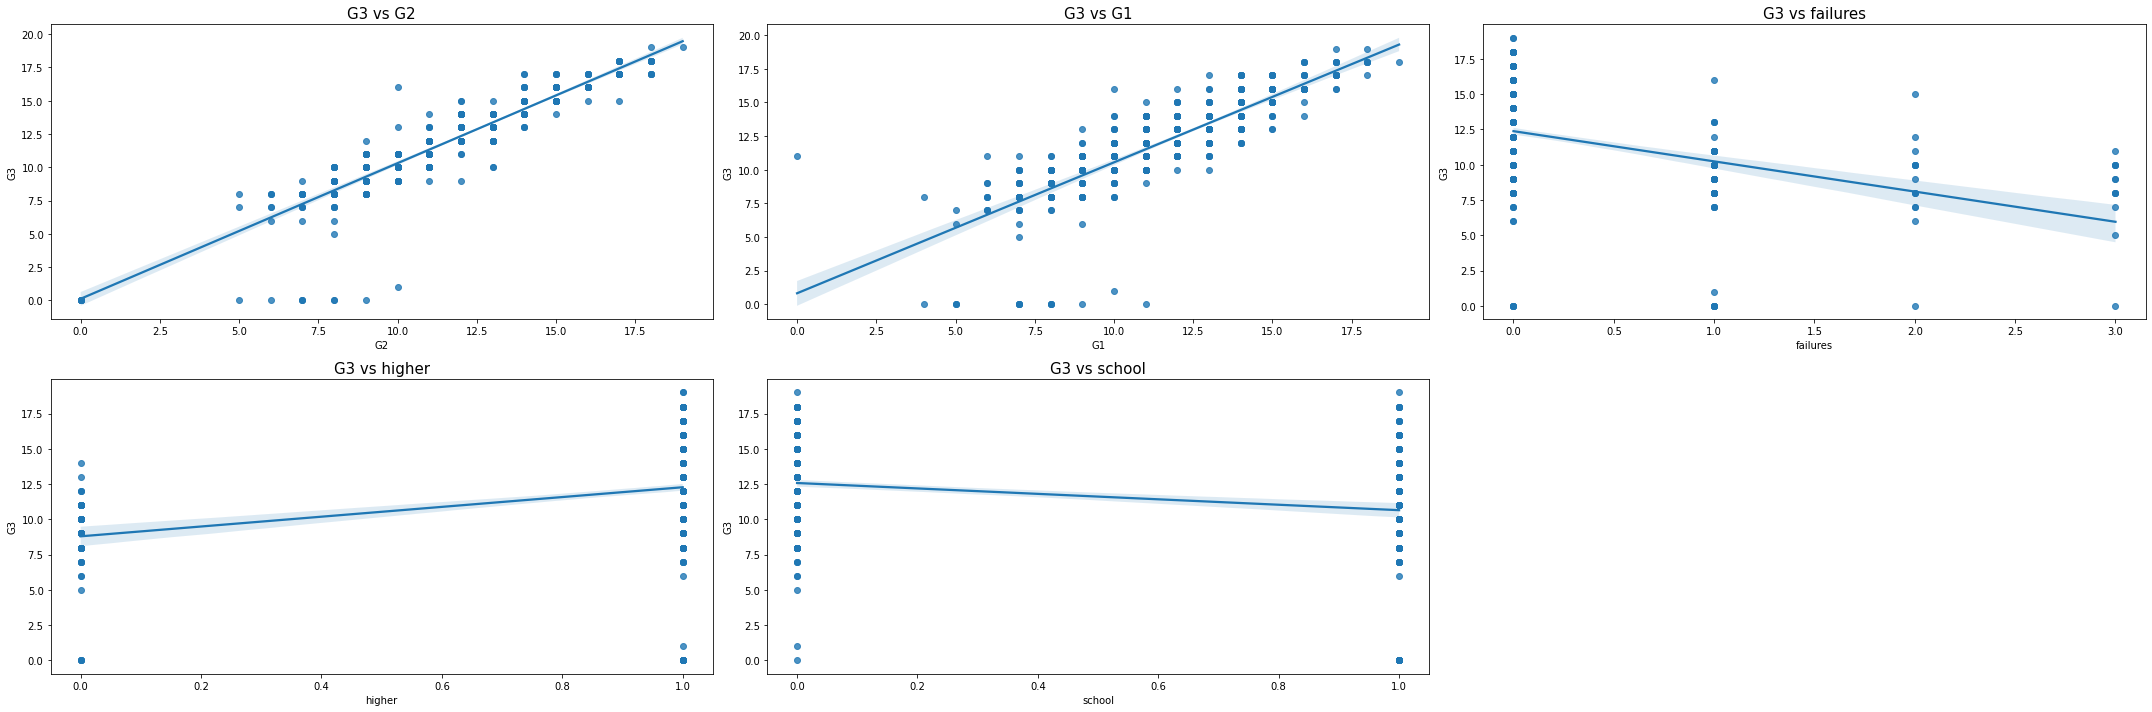

In [14]:
# visualization function
fig,ax = plt.subplots(2,3,figsize=(30,10))
flatax = ax.flatten()
flatax[-1].axis("off")
for i,feature in enumerate(features_to_viz):
    df = pd.concat([X_transformed[[feature]],y],axis=1)
    sns.regplot(data=df,x=feature,y="G3",ax=flatax[i])
    flatax[i].set_title("G3 vs "+feature,fontsize=15)

**Q2.4**: Briefly describe how these five variables influence the third semester grade G3. Are any of these relationships surprising? Are any of these relations likely to be causal? (4-5 sentences) 

**A2.4**:
* G2, G1 and willingness of pursuing higher education has a positive influence on the G3 grade, while the failures has a negative effect. 
* One of the surprising relationship is that the student in Gabriel Pereira performs better than the student in Mousinho da Silveira. 

* The G1 and G2 do have influence on the G3, since the previous grade reflect the average level of the study. The willingness of taking higher education also increase G3 by improving motivation to study. The failure does have negative effect.



## Part 3: Clustering and Dimensionality reduction (6 questions)

We will now try to group similar students together and identify potential groups of students. This can be useful to understand underlying structure in the classroom, to potentially adapt treatment. 

We want to be able to visualize our students in a reduced space. To do so, we will perform dimensionality reduction to transform the feature space ($n_{features} = 33$) into a 2D space. We will use a classical dimensionality reduction algorithm, Principal Components Analysis (PCA) to do so. 

**Q3.1**: Perform linear PCA on the transformed data (`X_transformed`) with 2 components and save the transformed data as as DataFrame named `dim_red_data` with column names `PC1` and `PC2`. What percent of the variance is explained by the two first components? (hint: use `sklearn.decomposition.PCA`, this will enable you to directly access the variance explained as a parameter) 

In [15]:
# Your code here
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_transformed)
X_transformed = scaler.transform(X_transformed)
pca = PCA(n_components = 2) 
components = pca.fit_transform(X_transformed)
dim_red_data = pd.DataFrame(components, columns = ['PC1', 'PC2'])

In [16]:
pca.explained_variance_ratio_

array([0.40501948, 0.25990736])

**A3.1**: 40.5% of variance is explained by the PC1 and 26.0% of variance is explained by the PC2.

We visualize what the students look like in a 2D space. 

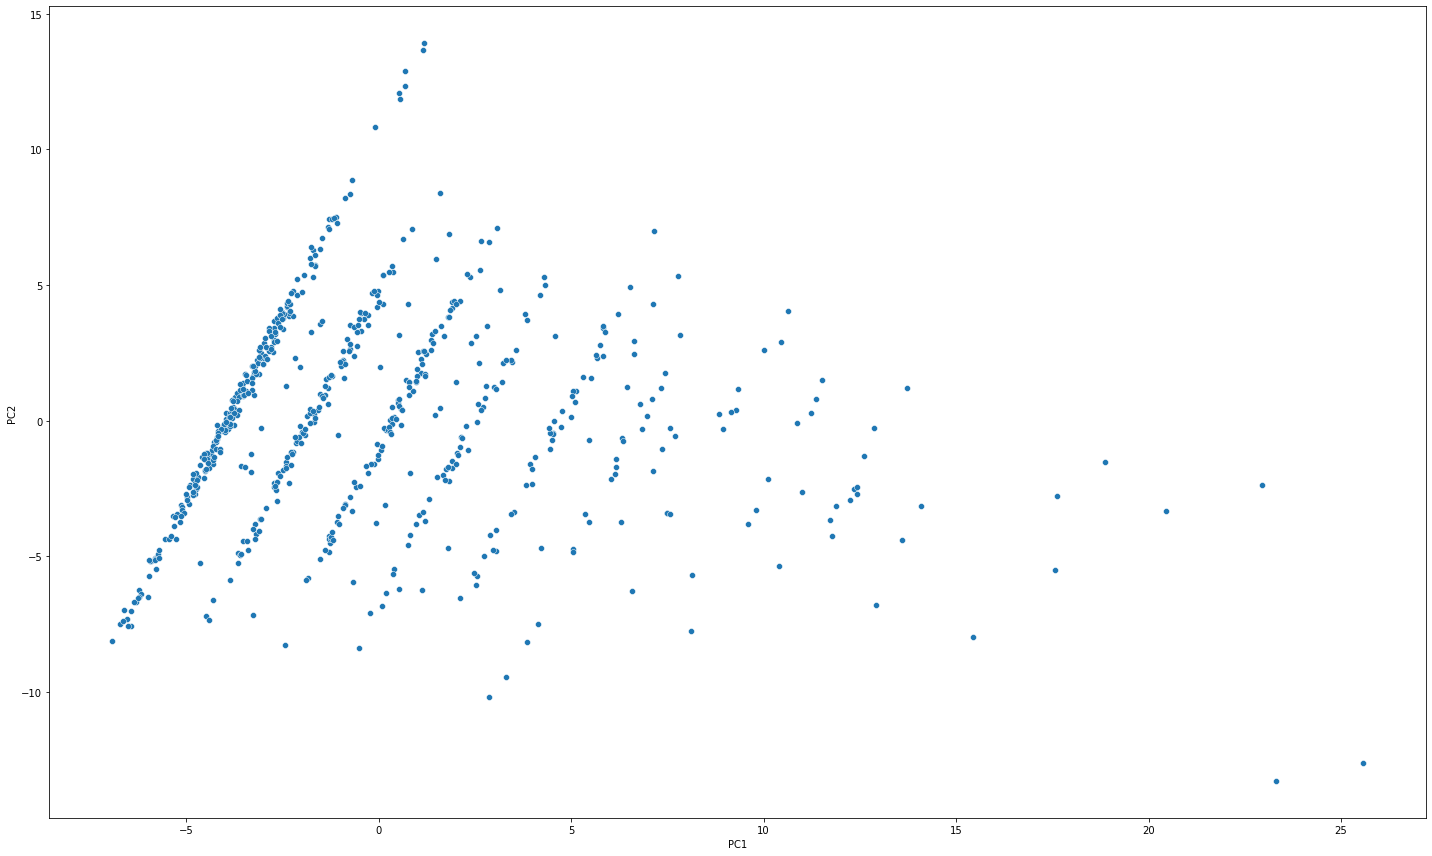

In [17]:
sns.scatterplot(data=dim_red_data,x="PC1",y="PC2")

**Q3.2**: Perfom KMeans clustering on the transformed dataset and save the cluster labels as `labels_km`. 

In [18]:
# Your code here
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 2).fit(X_transformed)
labels_km = kmeans.labels_

We now visualize what the clustering looks like in our 2D space.

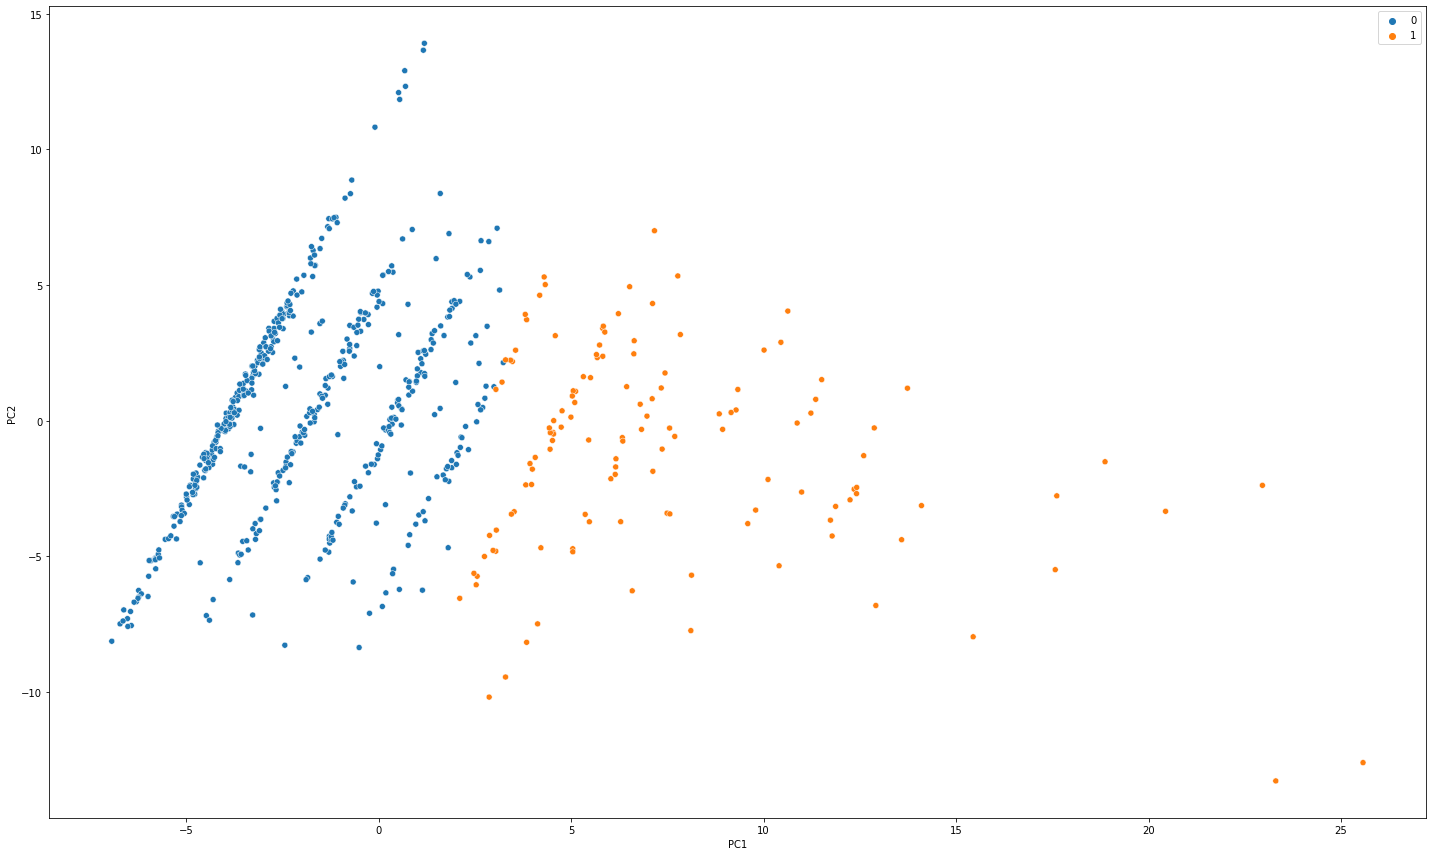

In [19]:
sns.scatterplot(data=dim_red_data,x="PC1",y="PC2",hue=labels_km)

We want to explore if this clustering is meaningful from a school performance point of view, *eg* if we can define a "poor performance" and "high performance" cluster. 

**Q3.3**: Observe the distribution of grades in your two clusters using the following code. Does one cluster perform better than the other? (1 sentence)

Explain what further analyses on the clusters you could conduct to understand if there are any underlying factors to the "poor" and "high" performance clusters. (2 sentences) 

**A3.3:** 
* In average, the cluster 0(blue) performs slightly better than cluster 1(orange). But it is not well clustered to poor and high performance.
* We can explicitly classify the students into two clusters according to the students' grade. Then we can visualize the class label in ["PC1", "PC2"] coordinate, and compare it with the cluster label to check if there are any underlying factors to the "poor" and "high" performance clusters. We can also select features that are highly correlated to G3 and then do PCA. Because the grade may not be the highest variance among the students, we should remove the features that creates high variance but not relevant to our object value (G3). 

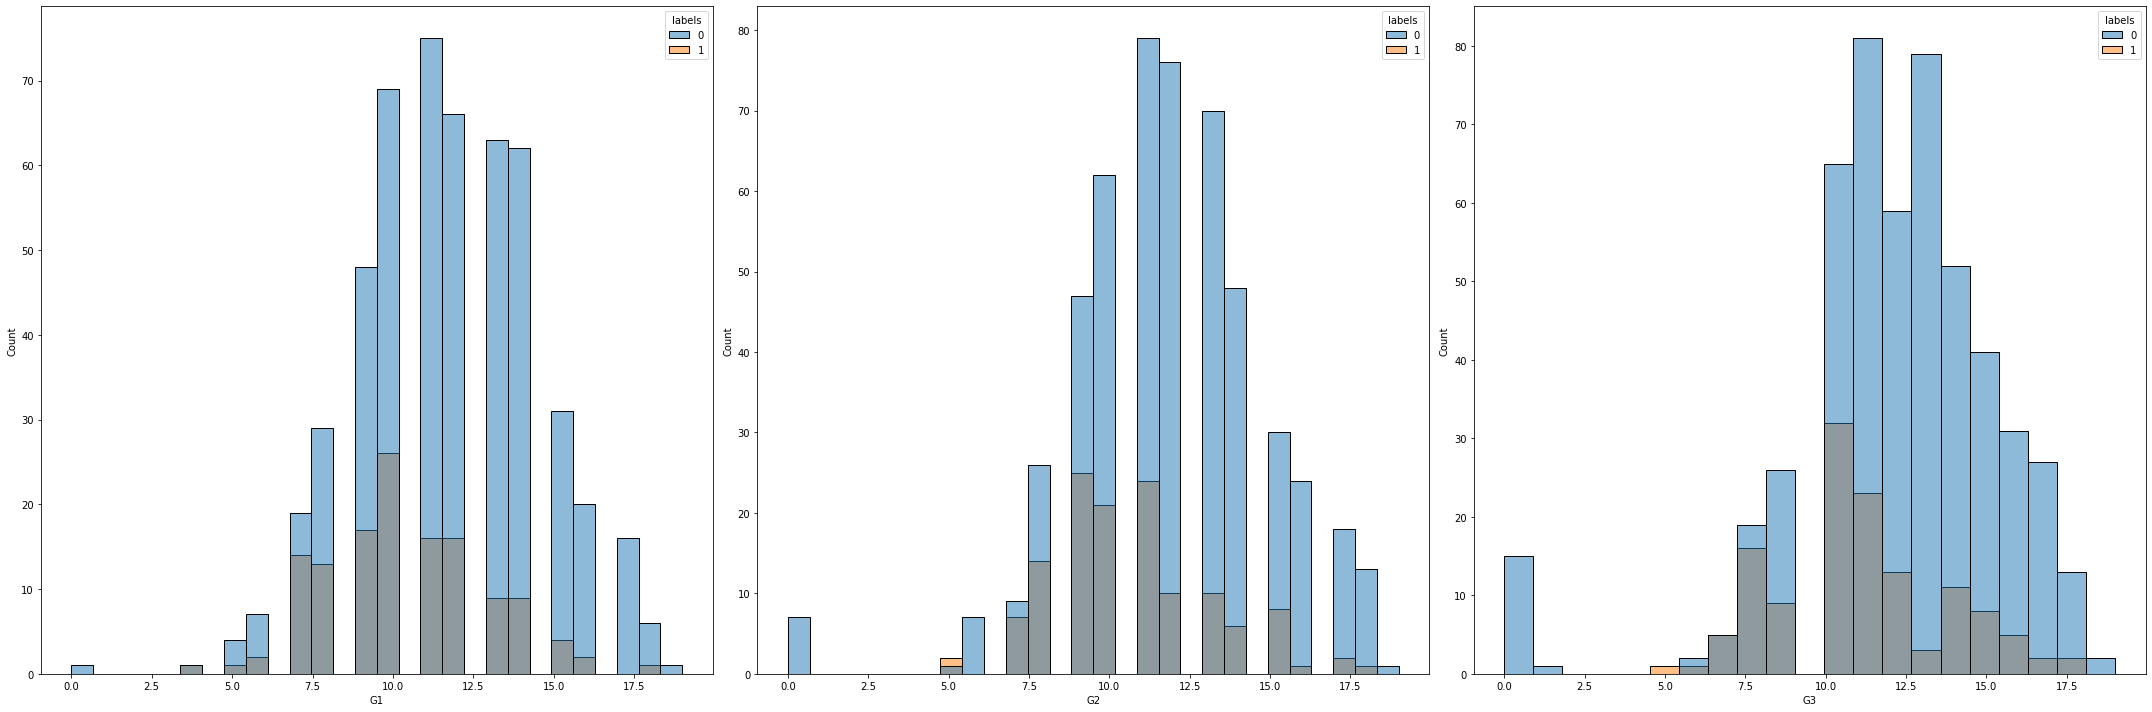

In [20]:
X_transf_wlabels = pd.concat([students_port,pd.DataFrame(labels_km,columns=["labels"],index=X.index)],axis=1)
fig,ax=plt.subplots(1,3,figsize=(30,10))
flatax = ax.flatten()
for i,feature in enumerate(["G1","G2","G3"]):
    sns.histplot(data=X_transf_wlabels,x=feature,hue="labels",ax=flatax[i])

We will now compare K-means to another well-known clustering technique, Gaussian Mixture Models. 

**Q3.4**: What are the underlying assumptions of K-means? Of Gaussian Mixture Models? (2-3 sentences)

**A3.4**: K-means assumes the clusters are spherical (each cluster has a center), while GMM assumes the clusters are different Gaussian distributions.

**Q3.5**: Train a Gaussian Mixture model with two components on your transformed data and save the discovered clusters as an `np.array` as `labels_gm`. 

In [21]:
# Your code here
from sklearn.mixture import GaussianMixture
labels_gm = GaussianMixture(n_components = 2).fit_predict(X_transformed)

In [26]:
print(abs(y[labels_gm==0].mean() - y[labels_gm==1].mean()) )
print(abs(y[labels_km==0].mean() - y[labels_km==1].mean()) )

G3    1.126332
dtype: float64
G3    1.077751
dtype: float64


We now visualize what the clustering looks like in our 2D space and how the grade distribution changes. 

**Q3.6**: What clustering algorithm would you choose in this case and why? (1-2 sentences) 

**A3.6**: 
* In this case, I will choose K-means cluster if we only observe the cluster result visualized in 2D. However, none of the methods can correctly cluster the higher and lower performance. If we observe the difference between the mean G3 of two clusters, GMM is better since the difference of G3 is larger between two clusters. 

* Since K-means seperate clusters with maximum distance (minimize the in-cluster distance), the result of K-means visualized on PCA (2 components) is better, because PCA finds the largest variance coordinates, and larger variance corresponds to larger distance in high dimension. But GMM may uses different variances for different directions in each cluster (the distance from different directions are weighted differently), therefore, the visualization of GMM result looks worse than PCA. **I think we cannot simply say which method is better given the cluster visulization in 2D.**

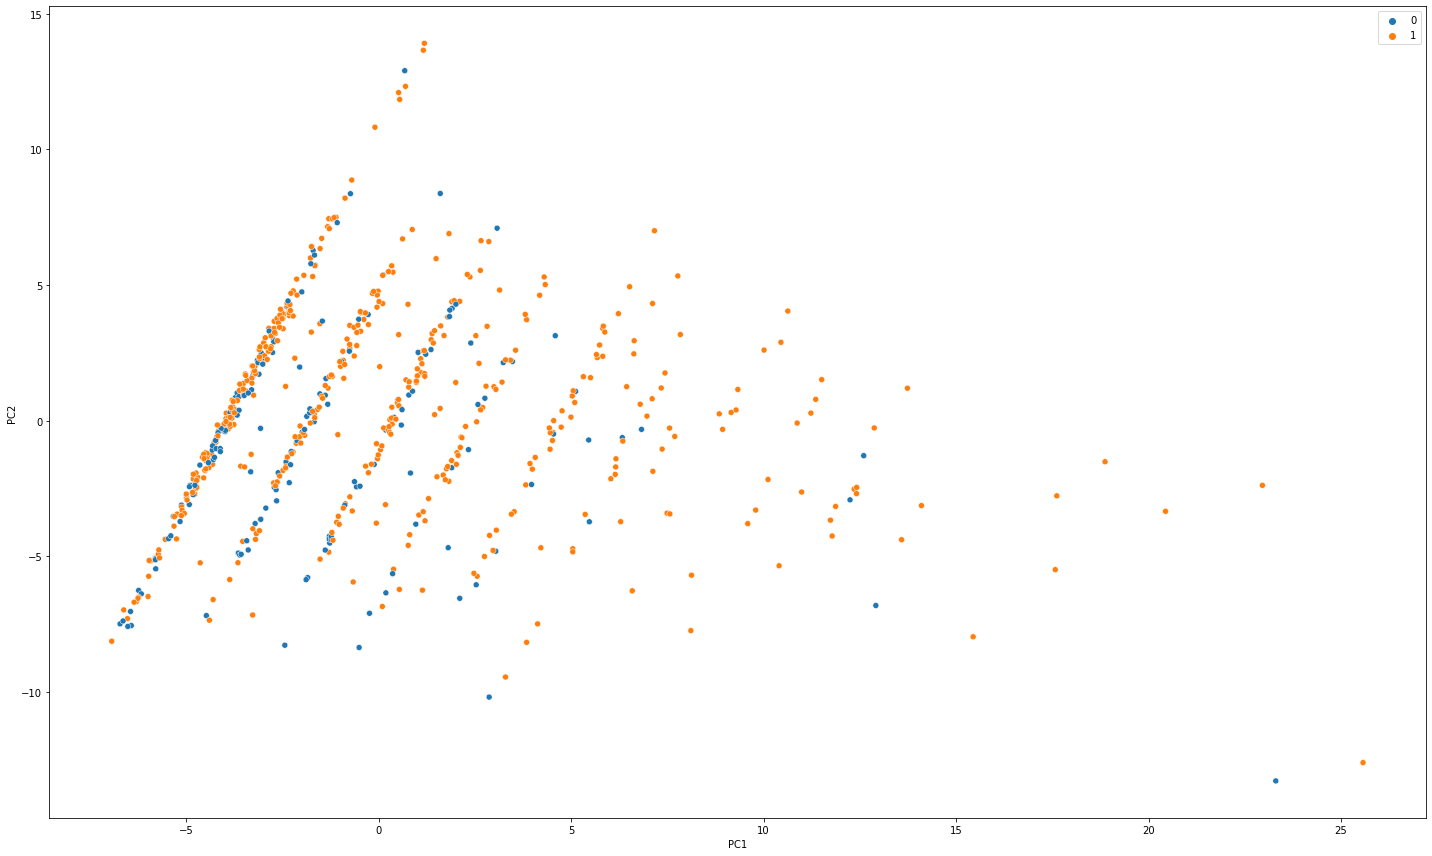

In [ ]:
sns.scatterplot(data=dim_red_data,x="PC1",y="PC2",hue=labels_gm)

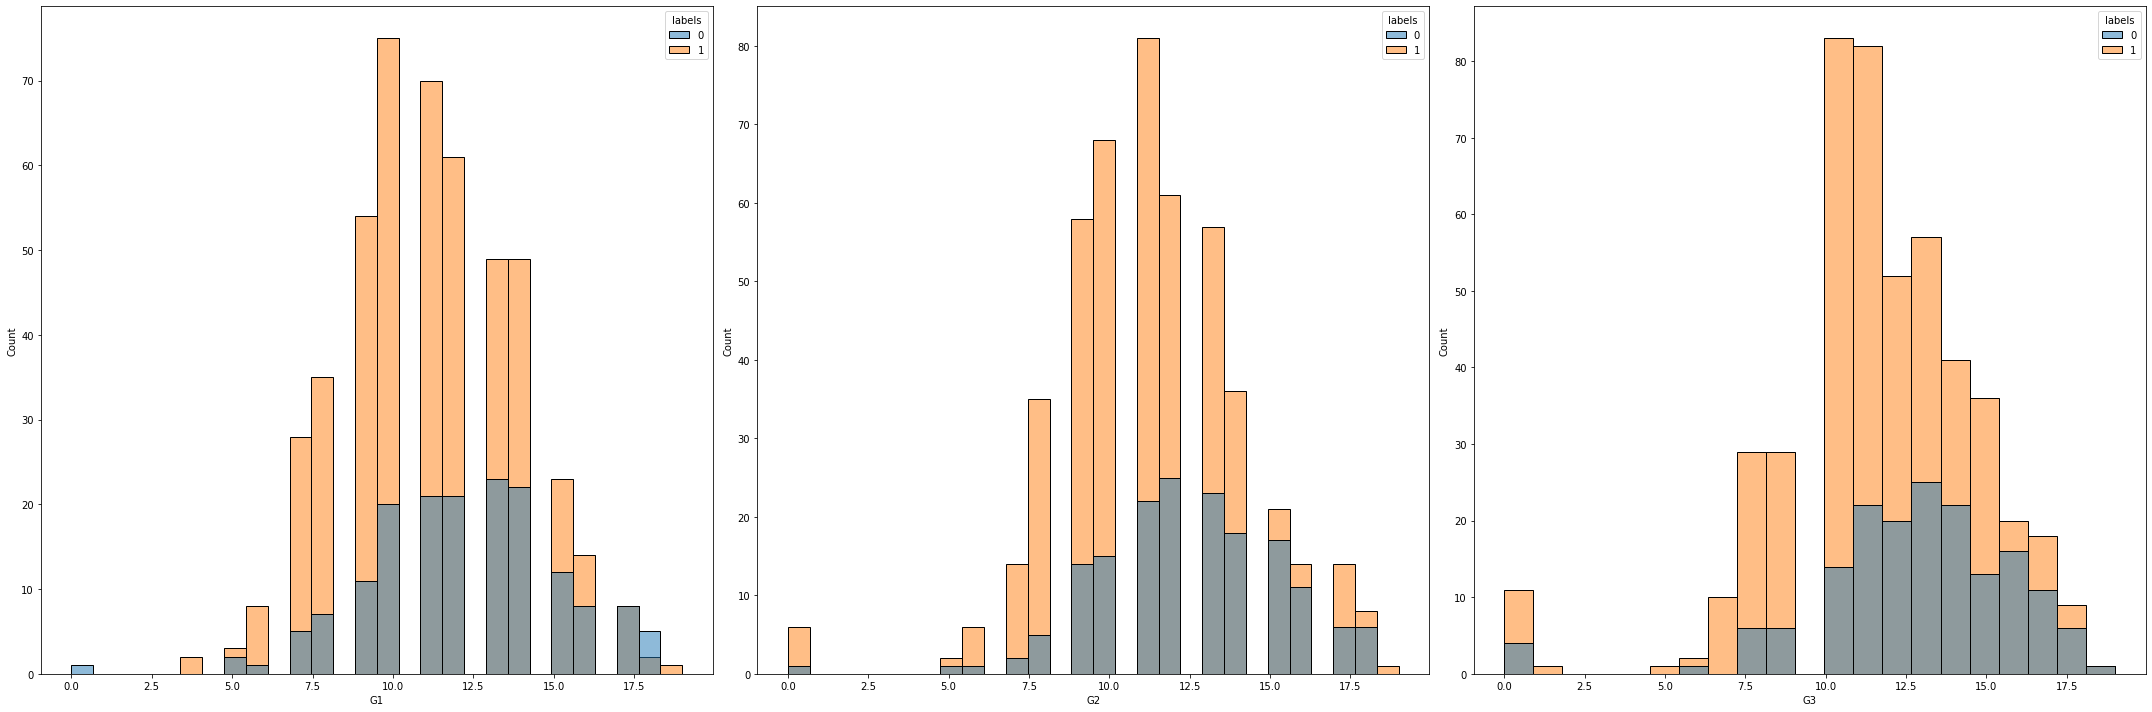

In [ ]:
X_transf_wlabels = pd.concat([students_port,pd.DataFrame(labels_gm,columns=["labels"],index=X.index)],axis=1)
fig,ax=plt.subplots(1,3,figsize=(30,10))
flatax = ax.flatten()
for i,feature in enumerate(["G1","G2","G3"]):
    sns.histplot(data=X_transf_wlabels,x=feature,hue="labels",ax=flatax[i])